### Basic model:
Features: Income, Household composition, Property type
Predict installed pV per household (aggregation level: buurt, no time dependency) 

Income: CBS data '84799NED' (Kerncijfers wijken en buurten 2020)

In [1]:
# pip install cbsodata

In [2]:
import cbsodata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#Read in (Kerncijfers wijken en buurten 2020
kerncijfers_2020 = '84799NED'
df_kerncijfers = pd.DataFrame(cbsodata.get_data(kerncijfers_2020))
df_kerncijfers.head()

,ID,WijkenEnBuurten,Gemeentenaam_1,SoortRegio_2,Codering_3,IndelingswijzigingWijkenEnBuurten_4,AantalInwoners_5,Mannen_6,Vrouwen_7,k_0Tot15Jaar_8,...,AfstandTotKinderdagverblijf_107,AfstandTotSchool_108,ScholenBinnen3Km_109,OppervlakteTotaal_110,OppervlakteLand_111,OppervlakteWater_112,MeestVoorkomendePostcode_113,Dekkingspercentage_114,MateVanStedelijkheid_115,Omgevingsadressendichtheid_116
0,0,Nederland,Nederland,Land,NL00,.,17407585,8648031,8759554,2726099,...,0.6,0.7,10.9,4154338,3367109,787228,.,NaN,2.0,2010.0
1,1,Aa en Hunze,Aa en Hunze,Gemeente,GM1680,.,25445,12708,12737,3460,...,1.2,1.2,1.8,27887,27609,279,.,NaN,5.0,281.0
2,2,Wijk 00 Annen,Aa en Hunze,Wijk,WK168000,1,3610,1760,1850,555,...,0.5,0.8,2.6,1478,1466,13,.,NaN,5.0,396.0
3,3,Annen,Aa en Hunze,Buurt,BU16800000,1,3460,1685,1775,540,...,0.5,0.8,2.6,252,252,0,9468,1.0,5.0,411.0
4,4,Verspreide huizen Annen,Aa en Hunze,Buurt,BU16800009,1,155,80,80,15,...,1.7,2.0,1.2,1226,1213,13,9468,1.0,5.0,60.0


Remove unusable items

In [4]:
df_kerncijfers = df_kerncijfers[df_kerncijfers['Codering_3'].isna() == False]

Keep only the data on Buurt level

In [5]:
#remove whitespaces from beginning and end of string column labels
df_kerncijfers = df_kerncijfers.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

is_buurt = df_kerncijfers['SoortRegio_2']=='Buurt'
df_kerncijfers = df_kerncijfers[is_buurt]

### Feature #1 - Income

Take a look at the number of buurten where the incomes are unknown

In [6]:
fraction_unfilled_incomes = df_kerncijfers['GemiddeldInkomenPerInwoner_72'].isna().sum()/ df_kerncijfers['GemiddeldInkomenPerInwoner_72'].sum() *100
print("Income not specified in: %.0f" % fraction_unfilled_incomes, "% of the buurten. Removing these entries.")

Income not specified in: 22 % of the buurten. Removing these entries.


<AxesSubplot:>

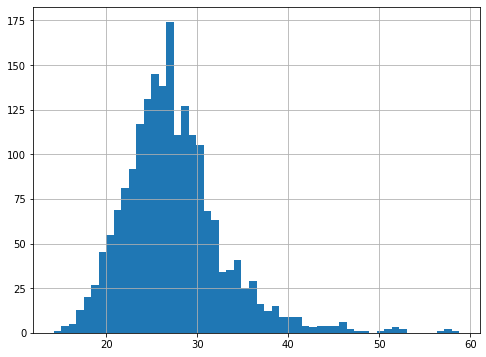

In [7]:
cutoff_income = 60
df_kerncijfers = df_kerncijfers[(df_kerncijfers['GemiddeldInkomenPerInwoner_72'].isna() == False)]

df_income_specified = df_kerncijfers[df_kerncijfers['GemiddeldInkomenPerInwoner_72'] < cutoff_income]
df_income_specified['GemiddeldInkomenPerInwoner_72'].hist(bins=54, figsize=(8, 6))

### Feature #2 - Household composition

In [8]:
fraction_unfilled_huishoudensgroottes = df_kerncijfers['GemiddeldeHuishoudensgrootte_32'].isna().sum()/ df_kerncijfers['GemiddeldeHuishoudensgrootte_32'].sum() *100

print("Average size of household not specified in: %.0f" % fraction_unfilled_huishoudensgroottes, "% of the buurten. Removing these entries.")

Average size of household not specified in: 0 % of the buurten. Removing these entries.


<AxesSubplot:>

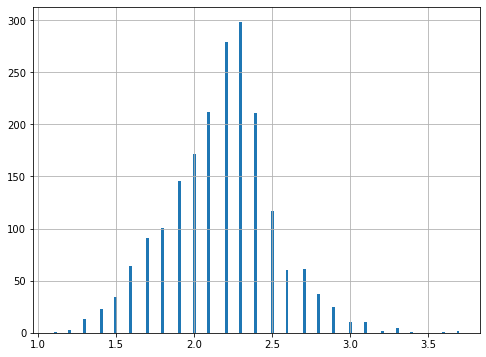

In [9]:
cut_off_household_size = 5
df_kerncijfers = df_kerncijfers[df_kerncijfers['GemiddeldeHuishoudensgrootte_32'].isna() == False]

df_average_household_size_specified = df_kerncijfers[df_kerncijfers['GemiddeldeHuishoudensgrootte_32']<cut_off_household_size]
df_average_household_size_specified['GemiddeldeHuishoudensgrootte_32'].hist(bins=140, figsize=(8, 6))

### Feature #3 - Percentage owned property (koopwoningen)

In [10]:
fraction_unfilled_owned_property_percentage = df_kerncijfers['Koopwoningen_40'].isna().sum()/ df_kerncijfers['Koopwoningen_40'].sum() *100

print("Average percentage of owned properties not specified in: %.0f" % fraction_unfilled_owned_property_percentage, "% of the buurten.")


Average percentage of owned properties not specified in: 0 % of the buurten.


Remove the 'BU' from the buurtcode and rename the column name so we can combine the datasets later

In [11]:
has_buurtcode_starting_with_BU = df_kerncijfers['Codering_3'].str.find('BU') == 0
buurtcodes_without_leading_BU = df_kerncijfers[has_buurtcode_starting_with_BU == False]
print("Number of buurten that don't start with 'BU': ", len(buurtcodes_without_leading_BU))

df_kerncijfers['CBS Buurtcode'] = pd.to_numeric(df_kerncijfers['Codering_3'].apply(lambda s:s.replace("BU","")))

Number of buurten that don't start with 'BU':  0


In [12]:
print("Duplicate buurtcodes: %.0f" % df_kerncijfers.duplicated(['CBS Buurtcode']).sum())
df_kerncijfers.astype({"CBS Buurtcode" : int})
df_kerncijfers.head()

Duplicate buurtcodes: 0


,ID,WijkenEnBuurten,Gemeentenaam_1,SoortRegio_2,Codering_3,IndelingswijzigingWijkenEnBuurten_4,AantalInwoners_5,Mannen_6,Vrouwen_7,k_0Tot15Jaar_8,...,AfstandTotSchool_108,ScholenBinnen3Km_109,OppervlakteTotaal_110,OppervlakteLand_111,OppervlakteWater_112,MeestVoorkomendePostcode_113,Dekkingspercentage_114,MateVanStedelijkheid_115,Omgevingsadressendichtheid_116,CBS Buurtcode
3,3,Annen,Aa en Hunze,Buurt,BU16800000,1,3460,1685,1775,540,...,0.8,2.6,252,252,0,9468,1.0,5.0,411.0,16800000
54,54,Gieten,Aa en Hunze,Buurt,BU16801700,1,4885,2360,2525,675,...,0.7,3.0,407,407,0,9461,1.0,4.0,520.0,16801700
62,62,Rolde,Aa en Hunze,Buurt,BU16801900,1,3770,1840,1930,470,...,0.9,1.0,333,333,0,9451,1.0,5.0,451.0,16801900
79,79,Centrum,Aalsmeer,Buurt,BU03580000,1,2785,1335,1445,365,...,0.5,3.0,61,54,7,1431,1.0,3.0,1070.0,3580000
80,80,Stommeer,Aalsmeer,Buurt,BU03580001,1,6535,3175,3360,955,...,0.8,3.2,192,184,8,1431,1.0,3.0,1205.0,3580001


Take a look at the # of households per buurt. We need this to be able to 'normalize' the installed pV

In [13]:
print("Huishoudens totaal has: ", (df_kerncijfers['HuishoudensTotaal_28'].isna() == True).sum(), " empty items.")

Huishoudens totaal has:  0  empty items.


In [14]:
df_kerncijfers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1979 entries, 3 to 17336
Columns: 119 entries, ID to CBS Buurtcode
dtypes: float64(74), int64(39), object(6)
memory usage: 1.8+ MB


## Target variable - opgesteld vermogen

Load the data from the Enexis supplied data file.

In [15]:
decentral_generation_072020 = 'Enexis_decentrale_opwek_kv_(zon_pv)_01072020.csv'
df_decentral_generation = pd.read_csv(decentral_generation_072020,
                         sep                = ';',
                         decimal            = ',',
                         thousands          = '.',
                         encoding           = 'unicode_escape')        

Remove empty items

In [16]:
df_decentral_generation = df_decentral_generation[df_decentral_generation['Opgesteld vermogen'].isna() == False]
df_decentral_generation = df_decentral_generation[df_decentral_generation['CBS Buurtcode'].isna() == False]

## Note: the unit of 'opgesteld vermogen' is kW

<AxesSubplot:>

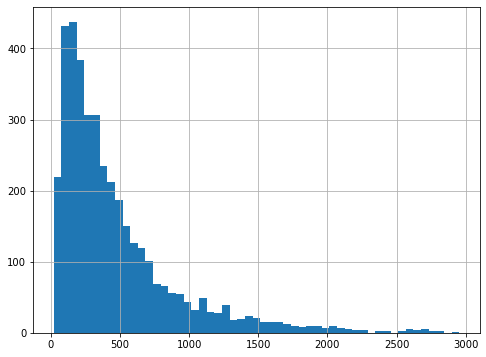

In [17]:
cut_off_generation = 3000

df_decentral_generation_specified = df_decentral_generation[df_decentral_generation['Opgesteld vermogen'] < cut_off_generation]
df_decentral_generation_specified['Opgesteld vermogen'].hist(bins=53, figsize=(8, 6))

In [18]:
print("Duplicate buurtcodes: %.0f" % df_decentral_generation.duplicated(['CBS Buurtcode']).sum())
df_decentral_generation.astype({"CBS Buurtcode" : int})

Duplicate buurtcodes: 0


,ï»¿Peildatum,Netbeheerder,Provincie,Gemeente,CBS Buurt,CBS Buurtcode,Aantal aansluitingen in CBS-buurt,Aantal aansluitingen met opwekinstallatie,Opgesteld vermogen
0,202007.0,Enexis,Drenthe,Aa en Hunze,Annen,16800000,1491.0,447.0,1866.0
1,202007.0,Enexis,Drenthe,Aa en Hunze,Verspreide huizen Annen,16800009,116.0,29.0,243.0
2,202007.0,Enexis,Drenthe,Aa en Hunze,Eext,16800100,559.0,143.0,565.0
3,202007.0,Enexis,Drenthe,Aa en Hunze,Verspreide huizen Eext,16800109,127.0,24.0,150.0
4,202007.0,Enexis,Drenthe,Aa en Hunze,Anloo,16800200,127.0,29.0,129.0
...,...,...,...,...,...,...,...,...,...
4070,202007.0,Enexis,Overijssel,Zwolle,Gerenlanden,1935140,1218.0,323.0,992.0
4071,202007.0,Enexis,Overijssel,Zwolle,Gerenbroek,1935150,1217.0,315.0,949.0
4072,202007.0,Enexis,Overijssel,Zwolle,Oude Mars,1935160,59.0,19.0,127.0
4073,202007.0,Enexis,Overijssel,Zwolle,Windesheim,1935200,143.0,34.0,165.0


Check if the deduplication was successfull

### Combine the demographic data with the generation data

In [19]:
print("Number of rows in 'kerncijfers': %.0f" % len(df_kerncijfers))
print("Number of rows in 'generation data': %.0f" % len(df_decentral_generation))

df = pd.merge(df_kerncijfers, df_decentral_generation, on="CBS Buurtcode", validate='one_to_one')
print("Number of rows in combined data set: %.0f" % len(df))


Number of rows in 'kerncijfers': 1979
Number of rows in 'generation data': 3946
Number of rows in combined data set: 597


#### To do: check why not more rows match on buurt code

### Introduce a normalized column. normalized_opgesteld_vermogen = opgesteld_vermogen / #households

In [20]:
df["normalized_opgesteld_vermogen"] = (df["Opgesteld vermogen"] / df["HuishoudensTotaal_28"])

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597 entries, 0 to 596
Columns: 128 entries, ID to normalized_opgesteld_vermogen
dtypes: float64(79), int64(39), object(10)
memory usage: 601.7+ KB


In [22]:
df.head()

,ID,WijkenEnBuurten,Gemeentenaam_1,SoortRegio_2,Codering_3,IndelingswijzigingWijkenEnBuurten_4,AantalInwoners_5,Mannen_6,Vrouwen_7,k_0Tot15Jaar_8,...,CBS Buurtcode,ï»¿Peildatum,Netbeheerder,Provincie,Gemeente,CBS Buurt,Aantal aansluitingen in CBS-buurt,Aantal aansluitingen met opwekinstallatie,Opgesteld vermogen,normalized_opgesteld_vermogen
0,3,Annen,Aa en Hunze,Buurt,BU16800000,1,3460,1685,1775,540,...,16800000,202007.0,Enexis,Drenthe,Aa en Hunze,Annen,1491.0,447.0,1866.0,1.248161
1,54,Gieten,Aa en Hunze,Buurt,BU16801700,1,4885,2360,2525,675,...,16801700,202007.0,Enexis,Drenthe,Aa en Hunze,Gieten,2350.0,529.0,2143.0,0.978539
2,62,Rolde,Aa en Hunze,Buurt,BU16801900,1,3770,1840,1930,470,...,16801900,202007.0,Enexis,Drenthe,Aa en Hunze,Rolde,1811.0,436.0,1757.0,1.024490
3,574,Alphen,Alphen-Chaam,Buurt,BU17230000,1,3325,1710,1620,540,...,17230000,202007.0,Enexis,Noord-Brabant,Alphen-Chaam,Alphen,1449.0,180.0,786.0,0.567509
4,578,Chaam,Alphen-Chaam,Buurt,BU17230100,1,2865,1410,1455,415,...,17230100,202007.0,Enexis,Noord-Brabant,Alphen-Chaam,Chaam,1242.0,143.0,621.0,0.502834


## EDA - impact of demographic features on installed pv capacity

Creating the list of features

In [23]:
metadata = pd.read_csv('CBS Metadata.csv',
                         sep                = ';',
                         decimal            = ',',
                         thousands          = '.',
                         encoding           = 'utf-8')  

In [24]:
metadata.head()

,Key,Variable type
0,WijkenEnBuurten,Nominal
1,Gemeentenaam_1,Nominal
2,SoortRegio_2,Nominal
3,Codering_3,Nominal
4,IndelingswijzigingWijkenEnBuurten_4,Nominal


In [25]:
features_ext = metadata[metadata['Variable type'] == 'Extensive']['Key'].to_list()

In [26]:
# let's keep the number of households as is, to take account of the correlation of the size of the buurt with installed PV
features_ext.remove('HuishoudensTotaal_28')

In [27]:
features_ext

['AantalInwoners_5',
 'WestersTotaal_17',
 'NietWestersTotaal_18',
 'Woningvoorraad_34',
 'OpleidingsniveauLaag_64',
 'OpleidingsniveauMiddelbaar_65',
 'OpleidingsniveauHoog_66',
 'AantalInkomensontvangers_70',
 'BedrijfsvestigingenTotaal_91',
 'PersonenautoSTotaal_99',
 'Motorfietsen_104']

In [28]:
# Extensive features converted into intensive by deviding by number of households
for feat in features_ext:
    df[feat] = (df[feat] / df["HuishoudensTotaal_28"])

In [29]:
features = [
 'normalized_opgesteld_vermogen',
 'Gemeentenaam_1',
 'AantalInwoners_5',
 'WestersTotaal_17',
 'NietWestersTotaal_18',
 'HuishoudensTotaal_28',
 'GemiddeldeHuishoudensgrootte_32',
 'Bevolkingsdichtheid_33',
 'Woningvoorraad_34',
 #'GemiddeldeWoningwaarde_35',
 'PercentageEengezinswoning_36',
 'PercentageMeergezinswoning_37',
 'PercentageBewoond_38',
 'PercentageOnbewoond_39',
 'Koopwoningen_40',
 'InBezitWoningcorporatie_42',
 'InBezitOverigeVerhuurders_43',
 'BouwjaarVoor2000_45',
 'BouwjaarVanaf2000_46',
 'GemiddeldElektriciteitsverbruikTotaal_47',
 'GemiddeldAardgasverbruikTotaal_55',
 'PercentageWoningenMetStadsverwarming_63',
 'OpleidingsniveauLaag_64',
 'OpleidingsniveauMiddelbaar_65',
 'OpleidingsniveauHoog_66',
 'Nettoarbeidsparticipatie_67',
 'PercentageWerknemers_68',
 'PercentageZelfstandigen_69',
 'AantalInkomensontvangers_70',
 'GemiddeldInkomenPerInkomensontvanger_71',
 'GemiddeldInkomenPerInwoner_72',
 'GemGestandaardiseerdInkomenVanHuish_75',
 'BedrijfsvestigingenTotaal_91',
 'PersonenautoSTotaal_99',
 'PersonenautoSPerHuishouden_102',
 'PersonenautoSNaarOppervlakte_103',
 'Motorfietsen_104',
 'AfstandTotHuisartsenpraktijk_105',
 'AfstandTotGroteSupermarkt_106',
 'AfstandTotSchool_108',
 'MeestVoorkomendePostcode_113',
 'Dekkingspercentage_114',
 'MateVanStedelijkheid_115',
 'Omgevingsadressendichtheid_116']

In [30]:
df = df[features]

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597 entries, 0 to 596
Data columns (total 43 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   normalized_opgesteld_vermogen             597 non-null    float64
 1   Gemeentenaam_1                            597 non-null    object 
 2   AantalInwoners_5                          597 non-null    float64
 3   WestersTotaal_17                          597 non-null    float64
 4   NietWestersTotaal_18                      597 non-null    float64
 5   HuishoudensTotaal_28                      597 non-null    int64  
 6   GemiddeldeHuishoudensgrootte_32           597 non-null    float64
 7   Bevolkingsdichtheid_33                    597 non-null    float64
 8   Woningvoorraad_34                         597 non-null    float64
 9   PercentageEengezinswoning_36              597 non-null    float64
 10  PercentageMeergezinswoning_37         

In [32]:
corr_matrix = df.corr().sort_values(by = 'normalized_opgesteld_vermogen', ascending = False).transpose()
corr_matrix = corr_matrix.sort_values(by = 'normalized_opgesteld_vermogen', ascending = False)

<AxesSubplot:>

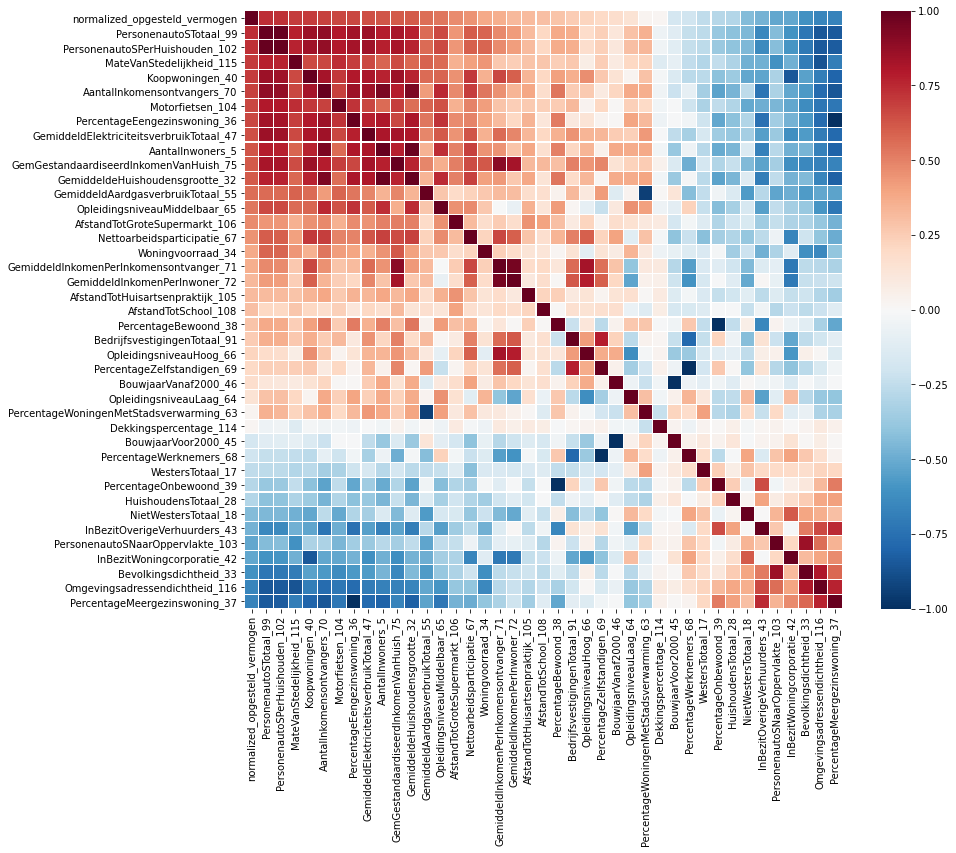

In [33]:
plt.figure(figsize = (14,11))
sns.heatmap(data = corr_matrix, annot = False, fmt='.2f', cmap = 'RdBu_r', linewidths=.1, square=True, vmax=1, center = 0)

<AxesSubplot:>

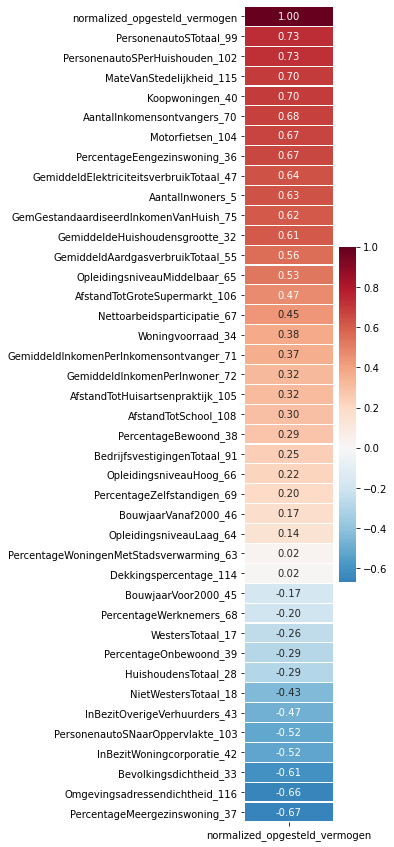

In [34]:
plt.figure(figsize = (2,15))
sns.heatmap(data = corr_matrix[['normalized_opgesteld_vermogen']], 
            annot = True, fmt='.2f', cmap = 'RdBu_r', linewidths=.1, square=False, vmax=1, center = 0)

In [35]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_num = df.select_dtypes(include=numerics).drop('HuishoudensTotaal_28', axis = 1)

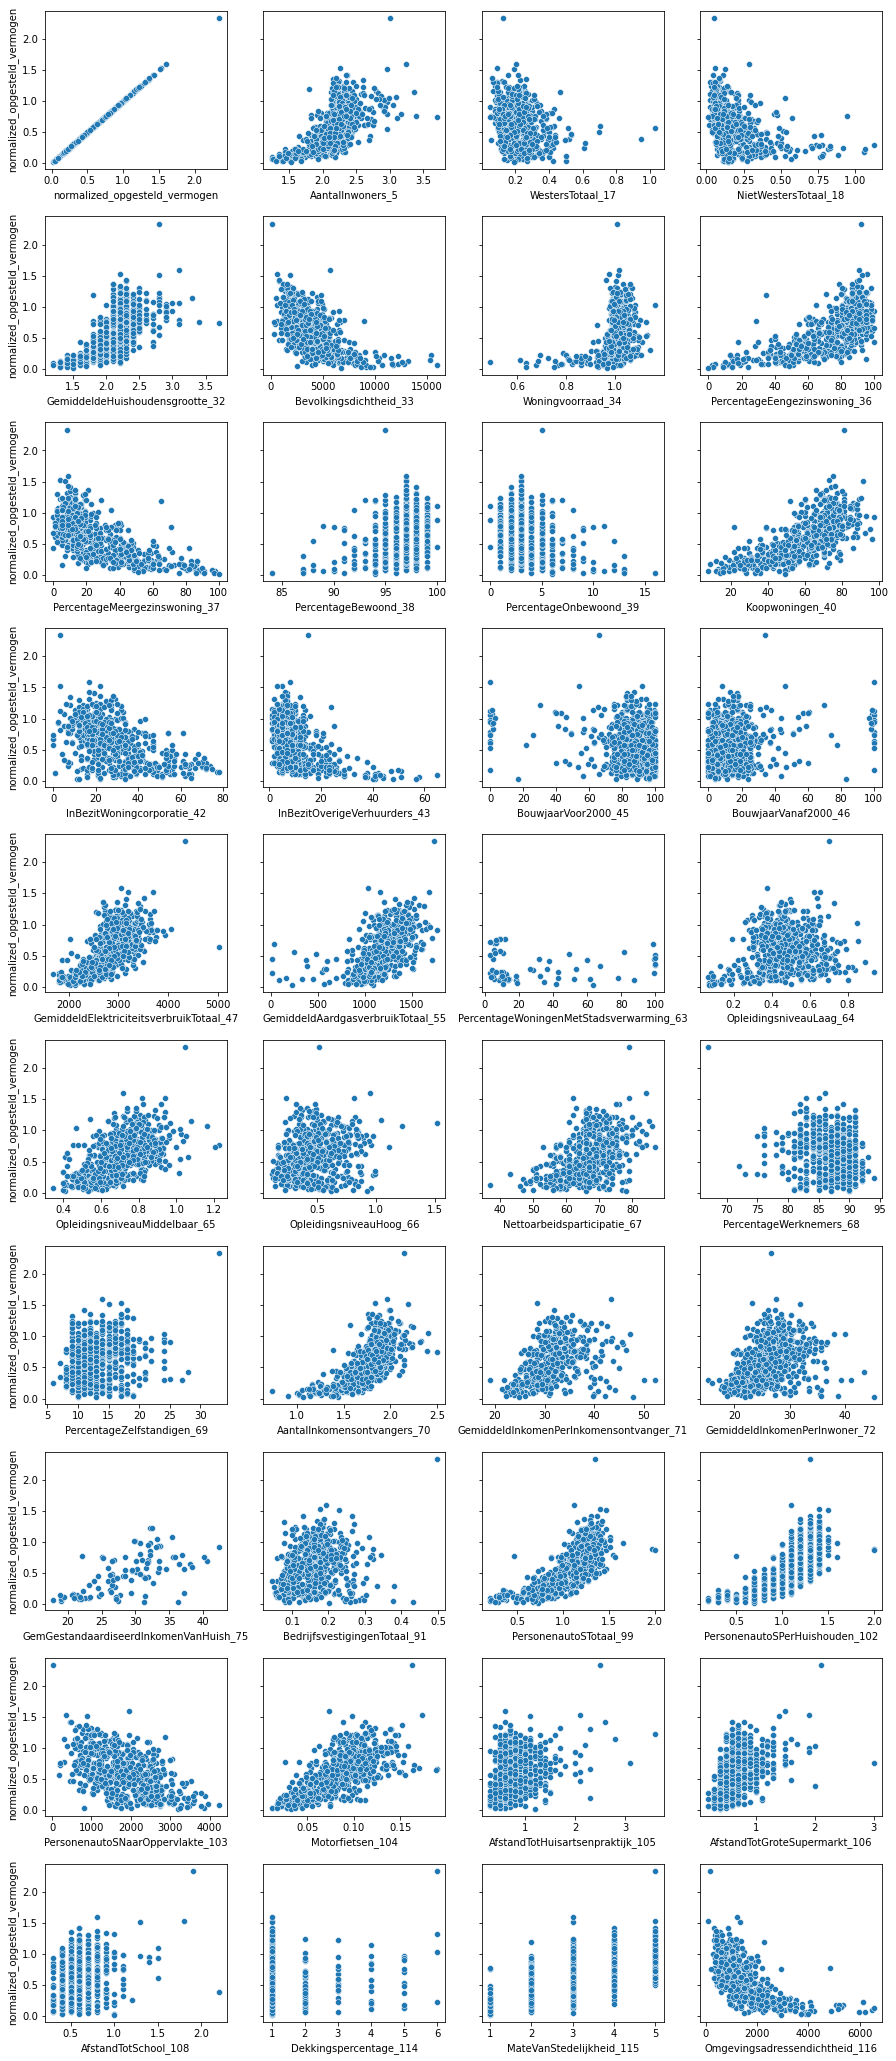

In [36]:
fig, ax = plt.subplots(10, 4, figsize=(15,37), sharey=True, gridspec_kw={'hspace': 0.3})
for i, col in enumerate(df_num.columns):
    _ax=ax[i // 4, i % 4]
    sns.scatterplot(x=col, y='normalized_opgesteld_vermogen', data=df_num, ax=_ax)

In [37]:
#df = df_num.copy()

In [38]:
df.isna().sum()

normalized_opgesteld_vermogen                 0
Gemeentenaam_1                                0
AantalInwoners_5                              0
WestersTotaal_17                              0
NietWestersTotaal_18                          0
HuishoudensTotaal_28                          0
GemiddeldeHuishoudensgrootte_32               0
Bevolkingsdichtheid_33                        0
Woningvoorraad_34                             0
PercentageEengezinswoning_36                  0
PercentageMeergezinswoning_37                 0
PercentageBewoond_38                          0
PercentageOnbewoond_39                        0
Koopwoningen_40                               0
InBezitWoningcorporatie_42                    0
InBezitOverigeVerhuurders_43                  0
BouwjaarVoor2000_45                           0
BouwjaarVanaf2000_46                          0
GemiddeldElektriciteitsverbruikTotaal_47      0
GemiddeldAardgasverbruikTotaal_55             5
PercentageWoningenMetStadsverwarming_63 

In [39]:
#df = df.dropna()

## Create a first model - linear model (3 features)

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import altair as alt

In [41]:
opgesteld_vermogen = 'normalized_opgesteld_vermogen'
columns_to_keep = [opgesteld_vermogen, 'GemiddeldInkomenPerInwoner_72', 'GemiddeldeHuishoudensgrootte_32', 'Koopwoningen_40']
df1 = df[columns_to_keep]

train_set, test_set = train_test_split(df1, test_size=0.2)

print(f"training set size: {len(train_set)}\ntest set size: {len(test_set)}")

Y_train_set = train_set[opgesteld_vermogen]
X_train_set = train_set.drop(opgesteld_vermogen, axis=1).copy()

Y_test_set = test_set[opgesteld_vermogen]
X_test_set = test_set.drop(opgesteld_vermogen, axis=1).copy()

lin_reg = LinearRegression()
lin_reg.fit(X_train_set, Y_train_set)

training set size: 477
test set size: 120


LinearRegression()

Plot the fit with income

In [42]:
alt.renderers.enable('default')

base = alt.Chart(train_set).mark_circle().encode(
    alt.X('GemiddeldInkomenPerInwoner_72',
     title='# income'),
       alt.Y(opgesteld_vermogen,
     title='Opgesteld vermogen')
)

linear_fit = [
    base.transform_regression(
        "GemiddeldInkomenPerInwoner_72", opgesteld_vermogen, method="linear"
    )
    .mark_line()   
]

graph = alt.layer(base, *linear_fit)
graph

alt.LayerChart(...)

#### Check the quality of the model

In [43]:
# Make predictions using the testing set
y_pred = lin_reg.predict(X_test_set)

# The coefficients
print("Coefficients: \n", lin_reg.coef_)
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(Y_test_set, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_test_set, y_pred))

Coefficients: 
 [-0.01040873  0.1265843   0.01289667]
Mean squared error: 0.077
Coefficient of determination: 0.41


## Linear regression model with standard scaler (all the features)

In [44]:
from sklearn.pipeline import make_pipeline, Pipeline 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV         
from sklearn import metrics, set_config
set_config(display="diagram")
RANDOM_STATE = 42
TEST_SIZE = 0.5

In [45]:
X = df.drop(['normalized_opgesteld_vermogen'], axis = 1)

In [46]:
y = df['normalized_opgesteld_vermogen']

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [48]:
X_train.shape

(298, 42)

In [49]:
categorical_features = ['Gemeentenaam_1', 'MeestVoorkomendePostcode_113']

In [50]:
numeric_features = X.columns.tolist()

In [51]:
numeric_features.remove('Gemeentenaam_1')

In [52]:
numeric_features.remove('MeestVoorkomendePostcode_113')

In [53]:
numeric_features

['AantalInwoners_5',
 'WestersTotaal_17',
 'NietWestersTotaal_18',
 'HuishoudensTotaal_28',
 'GemiddeldeHuishoudensgrootte_32',
 'Bevolkingsdichtheid_33',
 'Woningvoorraad_34',
 'PercentageEengezinswoning_36',
 'PercentageMeergezinswoning_37',
 'PercentageBewoond_38',
 'PercentageOnbewoond_39',
 'Koopwoningen_40',
 'InBezitWoningcorporatie_42',
 'InBezitOverigeVerhuurders_43',
 'BouwjaarVoor2000_45',
 'BouwjaarVanaf2000_46',
 'GemiddeldElektriciteitsverbruikTotaal_47',
 'GemiddeldAardgasverbruikTotaal_55',
 'PercentageWoningenMetStadsverwarming_63',
 'OpleidingsniveauLaag_64',
 'OpleidingsniveauMiddelbaar_65',
 'OpleidingsniveauHoog_66',
 'Nettoarbeidsparticipatie_67',
 'PercentageWerknemers_68',
 'PercentageZelfstandigen_69',
 'AantalInkomensontvangers_70',
 'GemiddeldInkomenPerInkomensontvanger_71',
 'GemiddeldInkomenPerInwoner_72',
 'GemGestandaardiseerdInkomenVanHuish_75',
 'BedrijfsvestigingenTotaal_91',
 'PersonenautoSTotaal_99',
 'PersonenautoSPerHuishouden_102',
 'PersonenautoS

In [54]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [55]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [56]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [57]:
model_LR = Pipeline(steps=[('preprocessor', preprocessor),
                      ('estimator', LinearRegression())])

In [58]:
model_LR.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['AantalInwoners_5',
                                                   'WestersTotaal_17',
                                                   'NietWestersTotaal_18',
                                                   'HuishoudensTotaal_28',
                                                   'GemiddeldeHuishoudensgrootte_32',
                                                   'Bevolkingsdichtheid_33',
                                                   'Woningvoorraad_34',
                                                   'PercentageEengezinswoni...
                                                   'GemiddeldInkomenPerInkomensontvanger_71',
                                                   'GemiddeldInkomenPerInwoner_72',
                                                   'GemGestandaardiseerdInkomenVanHuish_75',
                                                   'BedrijfsvestigingenTotaal_91', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gemeentenaam_1',
                                                   'MeestVoorkomendePostcode_113'])])),
                ('estimator', LinearRegression())])

In [59]:
y_pred = model_LR.predict(X_test)

In [60]:
r2_score(y_test, y_pred)

-3.5629714558575465

## Random forest model

In [61]:
model_RF = Pipeline(steps=[('preprocessor', preprocessor),
                      ('estimator', RandomForestRegressor(n_jobs=-1,
                                                          random_state=RANDOM_STATE,
                                                          min_weight_fraction_leaf=0.005))])

In [62]:
model_RF.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['AantalInwoners_5',
                                                   'WestersTotaal_17',
                                                   'NietWestersTotaal_18',
                                                   'HuishoudensTotaal_28',
                                                   'GemiddeldeHuishoudensgrootte_32',
                                                   'Bevolkingsdichtheid_33',
                                                   'Woningvoorraad_34',
                                                   'PercentageEengezinswoni...
                                                   'GemGestandaardiseerdInkomenVanHuish_75',
                                                   'BedrijfsvestigingenTotaal_91', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gemeentenaam_1',
                                                   'MeestVoorkomendePostcode_113'])])),
                ('estimator',
                 RandomForestRegressor(min_weight_fraction_leaf=0.005,
                                       n_jobs=-1, random_state=42))])

In [63]:
y_pred = model_RF.predict(X_test)

In [64]:
r2_score(y_test, y_pred)

0.611084872948065

## Create a first model - tree model

In [65]:
from sklearn.tree import DecisionTreeRegressor

Create helper class

In [66]:
class Result:
  def __init__(self, r_squared, mean_squared_error):
    self.r_squared = r_squared
    self.mean_squared_error = mean_squared_error

In [67]:
results = {}

max_range = 10

# Fit regression models
for i in range(1, max_range):
    r = DecisionTreeRegressor(max_depth=i, random_state=3)
    r.fit(X_train_set, Y_train_set)
    y_predict = r.predict(X_test_set)
    results[i] = Result(r2_score(Y_test_set, y_predict), mean_squared_error(Y_test_set, y_predict)) 

#### Check the quality of the models

# Mark down

In [68]:
for i in range(1,max_range):
    print("Depth  %2.f" % i, ":R squared: %.2f" % results[i].r_squared,
    "-- Mean squared error: %.0f" % results[i].mean_squared_error)


Depth   1 :R squared: 0.25 -- Mean squared error: 0
Depth   2 :R squared: 0.36 -- Mean squared error: 0
Depth   3 :R squared: 0.39 -- Mean squared error: 0
Depth   4 :R squared: 0.38 -- Mean squared error: 0
Depth   5 :R squared: 0.41 -- Mean squared error: 0
Depth   6 :R squared: 0.35 -- Mean squared error: 0
Depth   7 :R squared: 0.38 -- Mean squared error: 0
Depth   8 :R squared: 0.36 -- Mean squared error: 0
Depth   9 :R squared: 0.35 -- Mean squared error: 0


Best performance is at depth = 2 (Not the same over runs &#9785; though)

In [69]:
optimum_depth = 5
print("Depth  %2.f" % optimum_depth, ":R squared: %.2f" % results[optimum_depth].r_squared,
    "-- Mean squared error: %.0f" % results[optimum_depth].mean_squared_error)

Depth   5 :R squared: 0.41 -- Mean squared error: 0


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d0604020-40e6-4d7d-a2ba-74ef2b385723' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>